In [2]:
import os

import numpy as np
import torch
import torchvision
from albumentations.pytorch import ToTensorV2
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import json
import albumentations
import itertools
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")

print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

cuda:0
Is CUDA supported by this system? True
CUDA version: 11.3
ID of current CUDA device: 0
Name of current CUDA device:NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
CATEGORY_NAMES = [
    '__background__', 'inlay'
]

# Create data set loader class
# looks for an annotations.json file in the dir_path
class GuitarInletDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.dir_structure = "../images"
        self.height = height
        self.width = width
        self.classes = classes

        # get the labels
        metadata_path = os.path.join(self.dir_path, "annotations.json")
        with open(metadata_path) as f:
            self.metadata = json.load(f)
            self.image_metadata = self.metadata['images']
            self.image_annotations = self.metadata['annotations']



    def __getitem__(self, idx):
        metadata = self.image_metadata[idx]
        image_name = metadata['file_name']
        image_path = os.path.join(self.dir_path, self.dir_structure, image_name)
        # get the image
        image = cv2.imread(image_path)

        # convert to RGB color
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # Resize the image for faster training
        resized_image = cv2.resize(image, (self.width, self.height))
        # convert to 0-1 values
        resized_image = resized_image / 255.0

        # get the labels
        image_width = metadata["width"]
        image_height = metadata["height"]

        # find the associated annotations
        annotations = list(filter(lambda a: a["image_id"] == metadata["id"], self.image_annotations))

        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for annotation in annotations:
            labels.append(annotation["category_id"])
            areas.append(annotation["area"])

            bbox = annotation["bbox"]

            # Get bounding boxes and scale according to image scaling
            # boxes in coco dataset format
            x_min = bbox[0]
            y_min = bbox[1]
            x_max = x_min + bbox[2]
            y_max = y_min + bbox[3]

            # scale boxes
            x_min = (x_min / image_width) * self.width
            x_max = (x_max / image_width) * self.width
            y_min = (y_min / image_height) * self.height
            y_max = (y_max / image_height) * self.height

            boxes.append([x_min, y_min, x_max, y_max])
            iscrowd.append(annotation["iscrowd"])

        # convert to tensors
        labels = torch.as_tensor(labels, dtype=torch.int64)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.int16)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = areas
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = resized_image,
                                     bboxes = target['boxes'],
                                     labels = labels)
            resized_image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return resized_image, target

    def __len__(self):
        return len(self.image_metadata)

In [4]:
# handle loading different size data
def collate_fn(batch):
    return tuple(zip(*batch))

# training transforms, add random variations
def get_train_transform():
    return albumentations.Compose([
        albumentations.Flip(0.5),
        albumentations.RandomRotate90(0.5),
        albumentations.MotionBlur(p=0.2),
        albumentations.MedianBlur(blur_limit=3, p=0.1),
        albumentations.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transform():
    return albumentations.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

In [5]:
# Create data loaders

batch_size=4
# size the images should be scaled to (for faster training)
scaled_width=512
scaled_height=512


train_set = GuitarInletDataset(dir_path='./data/train', width=scaled_width, height=scaled_height, classes=CATEGORY_NAMES, transforms=get_train_transform())
test_set = GuitarInletDataset(dir_path='./data/test', width=scaled_width, height=scaled_height, classes=CATEGORY_NAMES, transforms=get_valid_transform())
# the validation set is used for image visualizations
valid_set = GuitarInletDataset(dir_path='./data/validation', width=scaled_width, height=scaled_height, classes=CATEGORY_NAMES, transforms=get_valid_transform())


# transformations
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
valid_loader = DataLoader(valid_set, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)


print(f"Training set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")
print(f"Validation set size: {len(valid_set)}")

Training set size: 387
Test set size: 97
Validation set size: 2


In [6]:
# Get the center point of a box
# if is_flattened=False, expects boxes in [(start_x, start_y), (end_x, end_y)] format,
# otherwise [start_x, start_y, end_x, end_y]
def get_box_center(box, is_flattened=False):
    if not is_flattened:
        box_x = (box[0][0] + box[1][0]) / 2
        box_y = (box[0][1] + box[1][1]) / 2
        return box_x, box_y
    else:
        box_x = (box[0] + box[2])/2
        box_y = (box[1] + box[3])/2
        return box_x, box_y


In [7]:
# load the pre-trained object detection model, and modify the last layer to output the given number of classes
def generate_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [8]:
# number of classes to detect
num_classes = len(CATEGORY_NAMES)
model = generate_model(num_classes)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
# train the model using given data_loader
def train(model, data_loader, epochs=1, lr=0.01, momentum=0.9, decay=0.001, step_size=5, verbose=True):
    model.train()
    params = [p for p in model.parameters() if p.requires_grad]

    optimizer = optim.SGD(params, lr=lr, momentum=momentum, weight_decay=decay)

    # use a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,gamma=0.1)

    print("Starting training")

    loss_list = []
    for epoch in range(epochs):
        print("-------- Epoch: ", epoch+1)
        sum_loss = 0.0

        for i, batch in enumerate(data_loader, 0):
            optimizer.zero_grad()

            images, targets = batch

            images = list(image.to(device) for image in images)

            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # the model returns the cross entropy losses
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            loss_list.append(loss_value)
            sum_loss += loss_value

            losses.backward()
            optimizer.step()


            if i % 5 == 4:    # print every 5 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, sum_loss / 5))
                sum_loss = 0.0

        lr_scheduler.step()

    # save the model state so it can be loaded later
    torch.save(model.state_dict(), "model-state.bin")
    return loss_list

In [10]:
losses = None

In [11]:
# Set this to True to retrain the model
TRAIN = True
if TRAIN:
    losses = train(model, train_loader, epochs=20, lr=0.001, step_size=5)
    print(f"Final loss: {losses[-1]}")
else:
    model.load_state_dict(torch.load('./model-state.bin'))
    print("loaded model from save")

Starting training
-------- Epoch:  1
[1,     5] loss: 2.431
[1,    10] loss: 1.029
[1,    15] loss: 0.821
[1,    20] loss: 0.694
[1,    25] loss: 0.678
[1,    30] loss: 0.624
[1,    35] loss: 0.617
[1,    40] loss: 0.566
[1,    45] loss: 0.525
[1,    50] loss: 0.490
[1,    55] loss: 0.509
[1,    60] loss: 0.503
[1,    65] loss: 0.446
[1,    70] loss: 0.437
[1,    75] loss: 0.450
[1,    80] loss: 0.456
[1,    85] loss: 0.414
[1,    90] loss: 0.467
[1,    95] loss: 0.406
-------- Epoch:  2
[2,     5] loss: 0.438
[2,    10] loss: 0.403
[2,    15] loss: 0.376
[2,    20] loss: 0.369
[2,    25] loss: 0.384
[2,    30] loss: 0.362
[2,    35] loss: 0.371
[2,    40] loss: 0.404
[2,    45] loss: 0.373
[2,    50] loss: 0.371
[2,    55] loss: 0.376
[2,    60] loss: 0.381
[2,    65] loss: 0.344
[2,    70] loss: 0.352
[2,    75] loss: 0.369
[2,    80] loss: 0.334
[2,    85] loss: 0.340
[2,    90] loss: 0.336
[2,    95] loss: 0.343
-------- Epoch:  3
[3,     5] loss: 0.361
[3,    10] loss: 0.337
[3,  

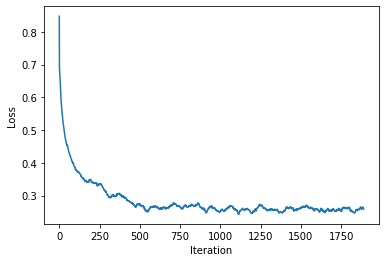

In [12]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

# Plot loss graph
if losses is not None:
    plt.plot(smooth(losses,50))
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.savefig('./loss-graph.jpg')

In [13]:
# Calculate model train and test accuracy by comparing box centers
# accuracy thresh is in pixel width
def calculate_accuracy(model, data_loader, confidence_thresh=0.5, accuracy_thresh=5):
    total_correct = 0
    total_predictions = 0

    for i, batch in enumerate(data_loader, 0):
      val_images, val_targets = batch
      val_images = list(image.to(device) for image in val_images)
      pred = model(val_images)

      for j in range(len(val_targets)):
          pred_class = [CATEGORY_NAMES[i] for i in list(pred[j]['labels'].detach().cpu().numpy())]
          pred_boxes = pred[j]['boxes'].detach().cpu().numpy()

          pred_score = list(pred[j]['scores'].detach().cpu().numpy())

          # filter by confidence threshold
          pred_t = [pred_score.index(x) for x in pred_score if x>confidence_thresh][-1]
          pred_boxes = pred_boxes[:pred_t+1]
          pred_class = pred_class[:pred_t+1]

          val_boxes = val_targets[j]['boxes']
          correct_box_predictions = 0

          for target in val_boxes:
              target_x, target_y = get_box_center(target, is_flattened=True)

              for box in pred_boxes:
                  box_x, box_y = get_box_center(box, is_flattened=True)
                  if abs(box_x - target_x) <= accuracy_thresh and abs(box_y - target_y) <= accuracy_thresh:
                      correct_box_predictions+=1
                      break
          if correct_box_predictions == len(val_boxes):
              # all boxes correctly predicted
              total_correct +=1

          total_predictions +=1

    return float(total_correct) / total_predictions

model.eval()
print("Calculating Model Accuracy")
train_accuracy = calculate_accuracy(model, train_loader)
print("train accuracy: {:.2f}%".format(train_accuracy * 100))
test_accuracy = calculate_accuracy(model, test_loader)
print("test accuracy: {:.2f}%".format(test_accuracy * 100))

Calculating Model Accuracy
train accuracy: 96.90%
test accuracy: 96.91%


In [14]:
# Use a RANSAC-like algorithm to get the guitar pose using a homography transform
# these are predefined pixel positions of the inlays in the reference frame
world_points = [(83.5, 256), (163, 283), (163, 229), (257.6, 256), (329.5, 256), (412, 256)]
world_points_all_combinations = list(itertools.permutations(world_points, r=len(world_points)))


def generate_matches(boxes, matching_points):
    n = len(boxes)

    matches = []
    for i in range(n):
        box = boxes[i]

        # Get the center point of the box
        box_x, box_y = get_box_center(box)
        world_point = matching_points[i]
        matches.append((world_point[0], world_point[1], box_x, box_y))

    return matches

# Use the matches to estimate the homography from reference frame coordinates -> image coordinates
def compute_homography(matches, n=4):
    M = torch.zeros((n*2, 8), dtype=torch.float32)
    b = torch.zeros((n*2, 1), dtype=torch.float32)

    for i in range(n):
        x = matches[i][0]
        y = matches[i][1]
        xp = matches[i][2]
        yp = matches[i][3]

        M[i*2, 0] = x
        M[i*2, 1] = y
        M[i*2, 2] = 1
        M[i*2, 3] = 0
        M[i*2, 4] = 0
        M[i*2, 5] = 0
        M[i*2, 6] = -x*xp
        M[i*2, 7] = -y*xp

        b[i*2, 0] = xp

        M[i*2+1, 0] = 0
        M[i*2+1, 1] = 0
        M[i*2+1, 2] = 0
        M[i*2+1, 3] = x
        M[i*2+1, 4] = y
        M[i*2+1, 5] = 1
        M[i*2+1, 6] = -x*yp
        M[i*2+1, 7] = -y*yp

        b[i*2+1, 0] = yp
    try:
        M.to(device)
        b.to(device)
        A = torch.linalg.solve(M, b)
        H = torch.zeros((3, 3), dtype=torch.float32)
        H[0, 0] = A[0, 0]
        H[0, 1] = A[1, 0]
        H[0, 2] = A[2, 0]
        H[1, 0] = A[3, 0]
        H[1, 1] = A[4, 0]
        H[1, 2] = A[5, 0]
        H[2, 0] = A[6, 0]
        H[2, 1] = A[7, 0]
        H[2, 2] = 1.0
        return H
    except RuntimeError as err:
        return None

# return number of inlier matches for a given homography transform
def model_inliers(homography, matches, thresh):
    count = 0
    for match in matches:
        point_x, point_y, box_x, box_y = match
        p = torch.tensor([point_x, point_y, 1.0], dtype=torch.float32)
        transformed_coord = torch.matmul(homography, p)
        w = transformed_coord[2]
        x = transformed_coord[0] / w
        y = transformed_coord[1] / w

        distance = pow(box_x - x, 2) + pow(box_y - y, 2)
        if(distance < thresh):
            count+=1

    return count

def RANSAC(boxes, inlier_thresh=5):
    print("permutations: ", len(world_points_all_combinations))

    start = time.process_time()

    best_inliers = 0
    best_homography = None


    for i in range(len(world_points_all_combinations)):
        points = world_points_all_combinations[i]
        matches = generate_matches(boxes, points)

        homography = compute_homography(matches)
        if homography is not None:
            inliers = model_inliers(homography, matches, thresh=10)
            if inliers > best_inliers:
                best_inliers = inliers
                best_homography = homography

                if best_inliers >= inlier_thresh:
                    print("early terminate")
                    break

    print(f"best inliers: {best_inliers}")
    print("RANSAC TIME: ", (time.process_time() - start))

    return best_homography, best_inliers

In [15]:
# Load visualization image (markers)
# must be a png image with an alpha channel
vis_image = cv2.imread('./data/vis-2.png', cv2.IMREAD_UNCHANGED) # keep alpha channel
# convert to RGB color
vis_image = cv2.cvtColor(vis_image, cv2.COLOR_BGRA2RGBA).astype(np.float32)
vis_image = vis_image / 255.0
vis_image = np.rollaxis(vis_image, 2, 0) # swap channel to start

permutations:  720
early terminate
best inliers: 6
RANSAC TIME:  0.0
total batch time:  1.765625
permutations:  720
best inliers: 4
RANSAC TIME:  0.546875
couldn't compute good homography for image


<Figure size 432x288 with 0 Axes>

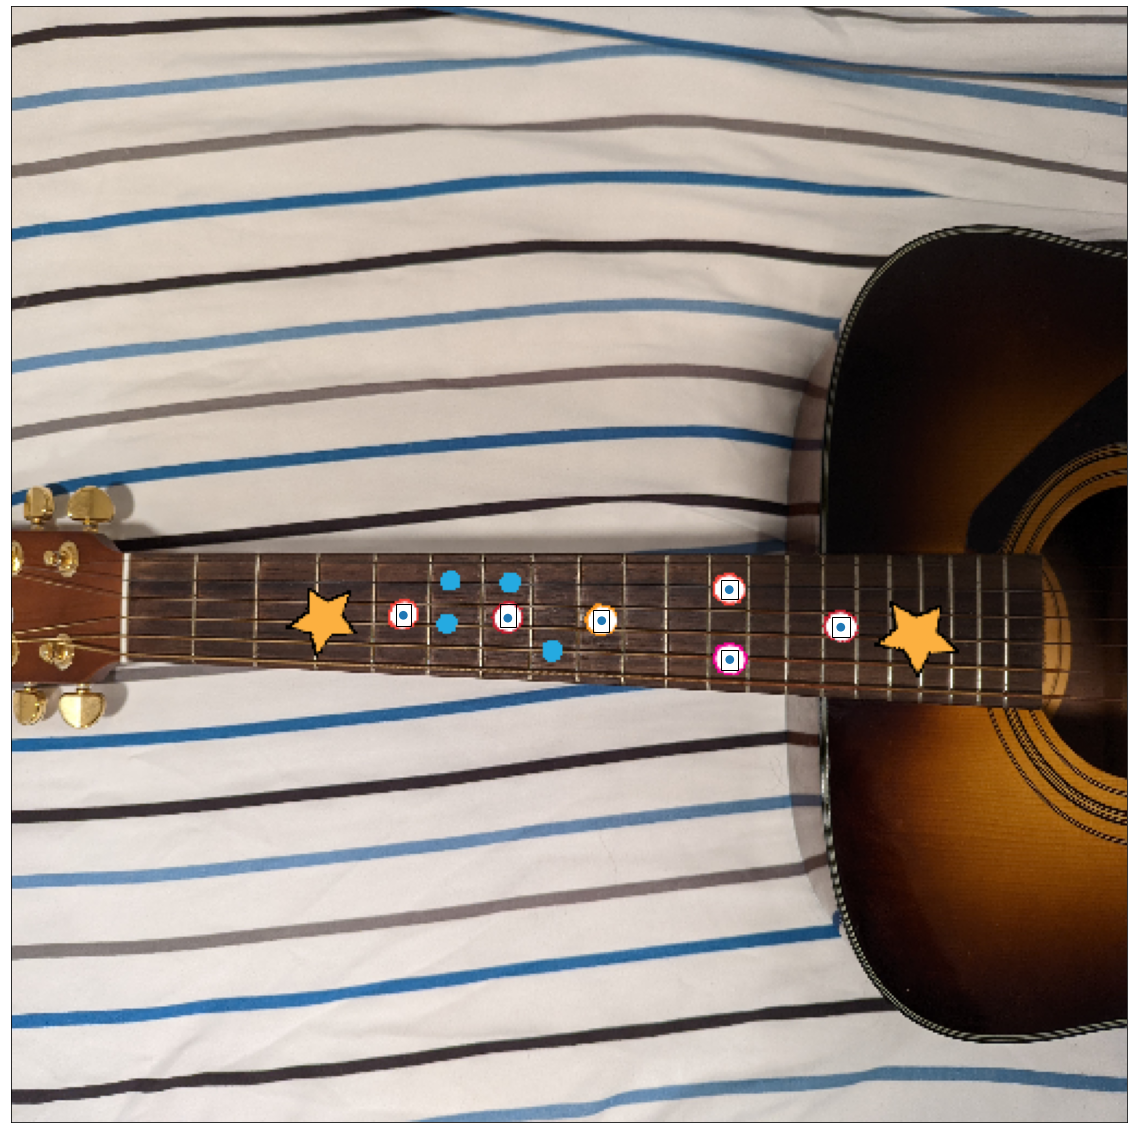

<Figure size 432x288 with 0 Axes>

In [16]:
# Run the pipeline -
# 1) Detect inlay positions
# 2) Compute optimal homography transform
# 3) Visualize markers

def pose_transform(data_loader, confidence=0.5):
  inlier_thresh = 6
  inlier_min_thresh = 6
  figure = plt.figure()

  for i, batch in enumerate(data_loader, 0):
      start = time.process_time()
      val_images, val_targets = batch
      val_images = list(image.to(device) for image in val_images)
      pred = model(val_images)

      pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
      pred_score = list(pred[0]['scores'].detach().cpu().numpy())
      pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
      pred_boxes = pred_boxes[:pred_t+1]

      boxes = pred_boxes
      homography, best_inliers = RANSAC(boxes, inlier_thresh=inlier_thresh)

      if best_inliers<inlier_min_thresh:
          # We skip images where the homography transform has insufficient inliers, because it tends to collapse space
          print("couldn't compute good homography for image")
          continue

      plt.figure(figsize=(20,30))
      img = val_images[0].detach().cpu()
      npimg = img.numpy()
      npimg = np.transpose(npimg, (1, 2, 0)) # swap the channel dimension to the front

      img_h, img_w, img_c = npimg.shape


      if homography is not None:
        homography.to(device)

        vis_image_c, vis_image_w, vis_image_h = vis_image.shape
        # collate every pixel in a tensor to speed up homography transform
        vis_image_points = np.zeros((3, vis_image_w*vis_image_h), dtype=np.float32)
        for x in range(vis_image_w):
            for y in range(vis_image_h):
                col = (y*vis_image_w + x)
                vis_image_points[0, col] = x
                vis_image_points[1, col] = y
                vis_image_points[2, col] = 1.0

        vis_image_points_tensor = torch.from_numpy(vis_image_points)
        vis_image_points_tensor.to(device)

        # compute the transform
        transformed_coords_tensor = torch.matmul(homography, vis_image_points_tensor)
        transformed_coords = transformed_coords_tensor.detach().cpu().numpy()

        # draw visualization markers over the image
        for x in range(vis_image_w):
            for y in range(vis_image_h):
                alpha = (vis_image[3, y, x]).item()
                if( alpha == 0):
                    # skip if pixel is transparent
                    continue

                col = (y*vis_image_w) + x
                transformed_coord = transformed_coords[:, col]
                w = transformed_coord[2]
                x_transformed = transformed_coord[0]/w
                y_transformed = transformed_coord[1]/w

                if x_transformed>=0 and x_transformed < img_w and y_transformed>=0 and y_transformed < img_h:
                    x_transformed = int(x_transformed)
                    y_transformed = int(y_transformed)


                    for channel in range(img_c):
                        pixel = (vis_image[channel, y, x]).item()
                        npimg[y_transformed, x_transformed , channel] = pixel



        plt.imshow(npimg)
        plt.xticks([])
        plt.yticks([])
        ax = plt.gca()

        # draw the predicted boxes on the image
        for i in range(len(boxes)):
          width = boxes[i][1][0] - boxes[i][0][0]
          height = boxes[i][1][1] - boxes[i][0][1]
          rect = patches.Rectangle(boxes[i][0], width, height, fill=False)
          ax.add_patch(rect)

        # draw circles where the inlay positions map
        for i in range(len(world_points)):
               point = world_points[i]
               p = torch.tensor([point[0], point[1], 1.0], dtype=torch.float32)
               p.to(device)
               transformed_coord = torch.matmul(homography, p)

               w = transformed_coord[2]
               x = transformed_coord[0]/w
               y = transformed_coord[1]/w
               if(x>0 and y>0 and x<img_w and y<img_h):
                   circle = patches.Circle((x, y), 2)
                   ax.add_patch(circle)


        print("total batch time: ", (time.process_time() - start))

  plt.show()
  plt.savefig('./validation-images.jpg')

model.eval()
# run the pipeline on the validation set
pose_transform(data_loader=valid_loader, confidence=0.7)



